In [1]:
import numpy as np
import pandas as pd
import time

import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

from IPython import display
%matplotlib inline

import matplotlib.ticker as tick

import sys
sys.path.append('..')
from nsgp_vi import nsgpVI


# We'll use double precision throughout for better numerics.
dtype = np.float64


tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 


2021-12-01 16:38:12.408392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#!pip install pickle5

In [3]:
import pickle5 as pickle

In [4]:
df = pd.read_csv('../data/ns_synthetic_data_indv_1_0.csv')
T = df['Time'].values[:,None]
ID = df['ID'].values
X = np.array(df['observations']).reshape(len(T),1)
true_len = np.array(df['Lengthscale']).reshape(len(T),1)
true_var = np.array(df['Variance']).reshape(len(T),1)

In [5]:
len(df)

8192

In [6]:
num_training_points_ = T.shape[0]
num_inducing_points_ = 50
inducing_index_points = np.linspace(0., 60*24., num_inducing_points_, endpoint=False)[..., np.newaxis]
np.random.shuffle(inducing_index_points)

In [7]:
# create the dataset

BATCH_SIZE=8#s
SEG_LENGTH=1024

allT = []
allX = []
for i in np.unique(df['ID'].values):
    allT.append(df['Time'][df['ID'].values == i].values[...,None])
    allX.append(df['observations'][df['ID'].values == i].values[...,None])

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            self.i = 0
            self.j +=1
            if self.j==self.max_j:
                raise StopIteration
            
        T = allT[self.i]
        X = allX[self.i] 

        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.i += 1

        return TT,XX

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64)) 
dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-01 16:38:17.207860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-01 16:38:17.208926: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 16:38:17.208967: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 16:38:17.209028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (euclid-05.maths.gla.ac.uk): /proc/driver/nvidia/version does not exist
2021-12-01 16:38:17.210546: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other ope

In [8]:
for d in dataset:
    print(d[0].shape)

(8, 1024, 1)


2021-12-01 16:38:19.932435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-01 16:38:19.933623: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


In [9]:
## set up the kernels and model

kernel_len_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(30.0,tfb.Chain([tfb.Scale(np.float64(60.)),tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(30.0,tfb.Chain([tfb.Scale(np.float64(60.)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=True)

    #kernels on the second layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=5,num_parallel_samples=10,init_observation_noise_variance=0.005**2)  


In [63]:
one_indiv_len =  BATCH_SIZE * SEG_LENGTH
# 5 datasets each for n1,n8,n128

standard_diff_len_matrix = np.ones((5,one_indiv_len)) 
diff_len_matrix =  np.ones((5,one_indiv_len)) 

standard_diff_amp_matrix = np.ones((5,one_indiv_len)) 
diff_amp_matrix =  np.ones((5,one_indiv_len))

#1,8,128
for ndv in [1,8,128]:
    random_id=random.randint(0, ndv-1)
    print(random_id)
    print(str(ndv) +'_' + 'data start')
    
    for nrd in range(0,4):
        
        df = pd.read_csv('../data/ns_synthetic_data_indv_' + str(ndv) + '_' + str(nrd) + '.csv') 
        T = df['Time'].values[:,None]
        ID = df['ID'].values
        X = np.array(df['observations']).reshape(len(T),1)
        true_len = np.array(df['Lengthscale']).reshape(len(T),1)
        true_var = np.array(df['Variance']).reshape(len(T),1)
        
        # select one random individual
        T = T[ID == random_id]
        X = X[ID == random_id]
        true_len = true_len[ID==random_id]
        true_var = true_var[ID==random_id]
                
        #Load the inducing points and the optimized parameters 
        with open('../results/opt_n' + str(ndv) + '_' + str(nrd) + '.pkl', 'rb') as f: 
            loadp = pickle.load(f)
        inducing_index_points = np.load('../results/T_ind_n' + str(ndv) + '_' + str(nrd) + '.npy')  
        
        # Construct our variational GP Distribution instance. 
        vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=10,num_parallel_samples=10,init_observation_noise_variance=0.005**2) 
    
        #Load the parameters !!!
        for np_v, tf_v in zip(loadp,vgp.trainable_variables):
            tf_v.assign(np_v)
            
        ZZ = T 
        len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
        len_mean = len_mean[0,:,0].numpy()
        len_std = len_var[:,0].numpy()**0.5
        
        
        amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
        amp_mean = amp_mean[0,:,0].numpy()
        amp_std = amp_var[:,0].numpy()**0.5
        
    
        diff_len = np.squeeze(tfp.math.softplus_inverse(true_len) - vgp.mean_len) - len_mean
        diff_amp = np.squeeze(tfp.math.softplus_inverse(true_var) - vgp.mean_amp) - amp_mean
        
        standard_diff_len = diff_len/len_std
        standard_diff_amp = diff_amp/amp_std
        
        standard_diff_len_matrix[nrd,:] = standard_diff_len 
        standard_diff_amp_matrix[nrd,:] = standard_diff_amp 
    
        diff_len_matrix[nrd,:] = diff_len 
        diff_amp_matrix[nrd,:] = diff_amp 
        
        np.save('standard_diff_len_matrix_n' +str(ndv),standard_diff_len_matrix)
        np.save('diff_len_matrix_n' + str(ndv),diff_len_matrix)
        np.save('standard_diff_amp_matrix_n' + str(ndv),standard_diff_len_matrix)
        np.save('diff_amp_matrix_n' + str(ndv),diff_amp_matrix)
    

1_data start
8192
8192
8192
8192
8192
8192
8192
8192
8_data start
65536
8192
65536
8192
65536
8192
65536
8192
128_data start
1048576
8192
1048576
8192
1048576
8192
1048576
8192


In [64]:
#for n1 
standard_diff_len_matrix_n1 = np.load('standard_diff_len_matrix_n1.npy')
standard_diff_amp_matrix_n1 = np.load('standard_diff_amp_matrix_n1.npy')

diff_len_matrix_n1 = np.load('diff_len_matrix_n1.npy')
diff_amp_matrix_n1 = np.load('diff_amp_matrix_n1.npy')

# for n8 
standard_diff_len_matrix_n8 = np.load('standard_diff_len_matrix_n8.npy')
standard_diff_amp_matrix_n8 = np.load('standard_diff_amp_matrix_n8.npy')

diff_len_matrix_n8 = np.load('diff_len_matrix_n8.npy')
diff_amp_matrix_n8 = np.load('diff_amp_matrix_n8.npy')

# for n128 
standard_diff_len_matrix_n128 = np.load('standard_diff_len_matrix_n128.npy')
standard_diff_amp_matrix_n128 = np.load('standard_diff_amp_matrix_n128.npy')

diff_len_matrix_n128 = np.load('diff_len_matrix_n128.npy')
diff_amp_matrix_n128 = np.load('diff_amp_matrix_n128.npy')

In [65]:
#standard_diff_len
standard_diff_len_n1 = np.concatenate((standard_diff_len_matrix_n1[0],standard_diff_len_matrix_n1[1],standard_diff_len_matrix_n1[2],standard_diff_len_matrix_n1[3],standard_diff_len_matrix_n1[4]))
standard_diff_len_n8 = np.concatenate((standard_diff_len_matrix_n8[0],standard_diff_len_matrix_n8[1],standard_diff_len_matrix_n8[2],standard_diff_len_matrix_n8[3],standard_diff_len_matrix_n8[4]))
standard_diff_len_n128 = np.concatenate((standard_diff_len_matrix_n128[0],standard_diff_len_matrix_n128[1],standard_diff_len_matrix_n128[2],standard_diff_len_matrix_n128[3],standard_diff_len_matrix_n128[4]))


In [66]:
#standard_diff_amp
standard_diff_amp_n1 = np.concatenate((standard_diff_amp_matrix_n1[0],standard_diff_amp_matrix_n1[1],standard_diff_amp_matrix_n1[2],standard_diff_amp_matrix_n1[3],standard_diff_amp_matrix_n1[4]))
standard_diff_amp_n8 = np.concatenate((standard_diff_amp_matrix_n8[0],standard_diff_amp_matrix_n8[1],standard_diff_amp_matrix_n8[2],standard_diff_amp_matrix_n8[3],standard_diff_amp_matrix_n8[4]))
standard_diff_amp_n128 = np.concatenate((standard_diff_amp_matrix_n128[0],standard_diff_amp_matrix_n128[1],standard_diff_amp_matrix_n128[2],standard_diff_amp_matrix_n128[3],standard_diff_amp_matrix_n128[4]))


In [67]:
#diff_len
diff_len_n1 = np.concatenate((diff_len_matrix_n1[0],diff_len_matrix_n1[1],diff_len_matrix_n1[2],diff_len_matrix_n1[3],diff_len_matrix_n1[4]))
diff_len_n8 = np.concatenate((diff_len_matrix_n8[0],diff_len_matrix_n8[1],diff_len_matrix_n8[2],diff_len_matrix_n8[3],diff_len_matrix_n8[4]))
diff_len_n128 = np.concatenate((diff_len_matrix_n128[0],diff_len_matrix_n128[1],diff_len_matrix_n128[2],diff_len_matrix_n128[3],diff_len_matrix_n128[4]))


In [68]:
#diff_amp
diff_amp_n1 = np.concatenate((diff_amp_matrix_n1[0],diff_amp_matrix_n1[1],diff_amp_matrix_n1[2],diff_amp_matrix_n1[3],diff_amp_matrix_n1[4]))
diff_amp_n8 = np.concatenate((diff_amp_matrix_n8[0],diff_amp_matrix_n8[1],diff_amp_matrix_n8[2],diff_amp_matrix_n8[3],diff_amp_matrix_n8[4]))
diff_amp_n128 = np.concatenate((diff_amp_matrix_n128[0],diff_amp_matrix_n128[1],diff_amp_matrix_n128[2],diff_amp_matrix_n128[3],diff_amp_matrix_n128[4]))


In [69]:

#kde code
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#standard diff 
kernel_standard_diff_len_n1=gaussian_kde(standard_diff_len_n1,bw_method=0.1)
kernel_standard_diff_amp_n1=gaussian_kde(standard_diff_amp_n1,bw_method=0.1)

kernel_standard_diff_len_n8=gaussian_kde(standard_diff_len_n8,bw_method=0.1)
kernel_standard_diff_amp_n8=gaussian_kde(standard_diff_amp_n8,bw_method=0.1)

kernel_standard_diff_len_n128=gaussian_kde(standard_diff_len_n128,bw_method=0.1)
kernel_standard_diff_amp_n128=gaussian_kde(standard_diff_amp_n128,bw_method=0.1)

# difference 
kernel_diff_len_n1=gaussian_kde(diff_len_n1,bw_method=0.1)
kernel_diff_amp_n1=gaussian_kde(diff_amp_n1,bw_method=0.1)

kernel_diff_len_n8=gaussian_kde(diff_len_n8,bw_method=0.1)
kernel_diff_amp_n8=gaussian_kde(diff_amp_n8,bw_method=0.1)

kernel_diff_len_n128=gaussian_kde(diff_len_n128,bw_method=0.1)
kernel_diff_amp_n128=gaussian_kde(diff_amp_n128,bw_method=0.1)




In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [ ]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
#grid = GridSearchCV(KernelDensity(kernel='gaussian'),
 #                  {'bandwidth': bandwidths})

In [ ]:
#grid.fit(diff_amp_n1[:, None])

In [ ]:
#grid.best_params_

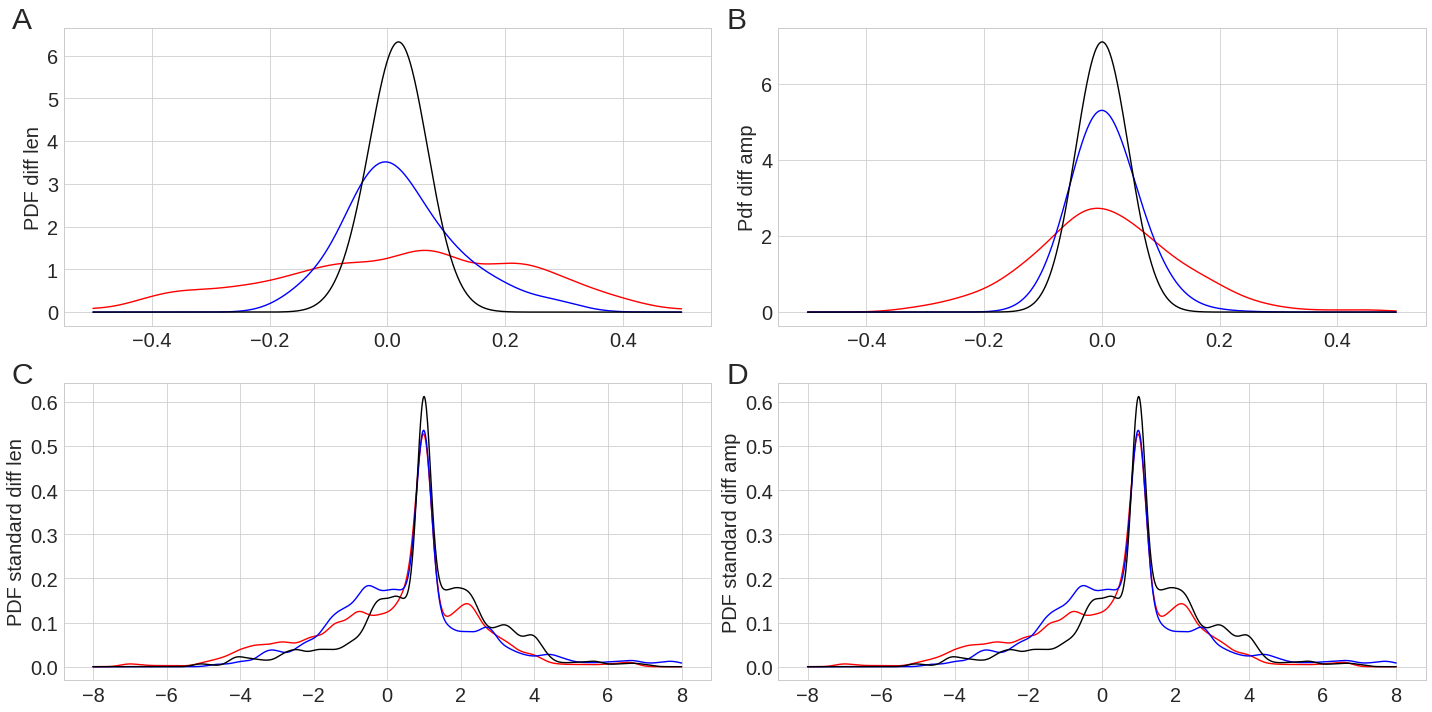

In [70]:
#create a 2x2 plot

x=np.linspace(-0.5,0.5,1000)
fig, axs = plt.subplots(2,2, figsize=(20,10))

ax0 = axs[0, 0].plot(x,kernel_diff_len_n1(x),'r-')
ax0 = axs[0, 0].plot(x,kernel_diff_len_n8(x),'b-')
ax0 = axs[0, 0].plot(x,kernel_diff_len_n128(x),'black')
#axs[0,0].set_xlabel('Time',size=20)
axs[0,0].set_ylabel('PDF diff len',size=20)
axs[0,0].text(-0.08,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params(axis='both', which='major', labelsize=20)


ax01 = axs[0, 1].plot(x,kernel_diff_amp_n1(x),'r-')
ax01 = axs[0, 1].plot(x,kernel_diff_amp_n8(x),'b-')
ax01 = axs[0, 1].plot(x,kernel_diff_amp_n128(x),'black')
#axs[0,1].set_xlabel('Time',size=20)
axs[0,1].set_ylabel('Pdf diff amp',size=20)
axs[0,1].text(-0.08,1,'B', size=30, transform=axs[0, 1].transAxes)
axs[0,1].tick_params(axis='both', which='major', labelsize=20)


x=np.linspace(-8,8,1000)
ax10 = axs[1, 0].plot(x,kernel_standard_diff_len_n1(x),'r-')
ax10 = axs[1, 0].plot(x,kernel_standard_diff_len_n8(x),'b-')
ax10 = axs[1, 0].plot(x,kernel_standard_diff_len_n128(x),'black')
#axs[1,0].set_xlabel('x',size=20)
axs[1,0].set_ylabel('PDF standard diff len',size=20)
axs[1,0].text(-0.08,1,'C', size=30, transform=axs[1, 0].transAxes)
axs[1,0].tick_params(axis='both', which='major', labelsize=20)

ax11 = axs[1, 1].plot(x,kernel_standard_diff_amp_n1(x),'r-')
ax11 = axs[1, 1].plot(x,kernel_standard_diff_amp_n8(x),'b-')
ax11 = axs[1, 1].plot(x,kernel_standard_diff_amp_n128(x),'black')
#axs[1,1].set_xlabel('x',size=20)
axs[1,1].set_ylabel('PDF standard diff amp',size=20)
axs[1,1].text(-0.08,1,'D', size=30, transform=axs[1, 1].transAxes)
axs[1,1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()

#plt.savefig("Synthetic-inference-unc-quantif-vi.png",dpi=600)


